In [25]:
%load_ext autoreload
%autoreload 2

import control as ct
from ctrl.controllers.mpc import *
import matplotlib.pyplot as plt
from copy import copy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:

def model(x, u):
    F = 0.0015
    G = 0.0025
    x_next = copy(x)
    x_next[0] += x[1]
    x_next[1] += u * F - np.cos(3 * x[0]) * G

    return x_next

# define plant
dt = 1

plant_update = lambda t, x, u, params: model(x, u)
plant_output = lambda t, x, u, params: x

plant = ct.NonlinearIOSystem(
    updfcn=plant_update,
    outfcn=plant_output,
    dt=dt,
    inputs=[f'u{i}' for i in range(1)],
    outputs=[f'x{i}' for i in range(2)],
    states=[f'x{i}' for i in range(2)],
    name='P'
)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      627
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      179

Total number of variables............................:      270
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      270
                     variables with only upper bounds:        0
Total number of equality constraints.................:      181
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.3250000e+01 5.00e-01 9.62e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

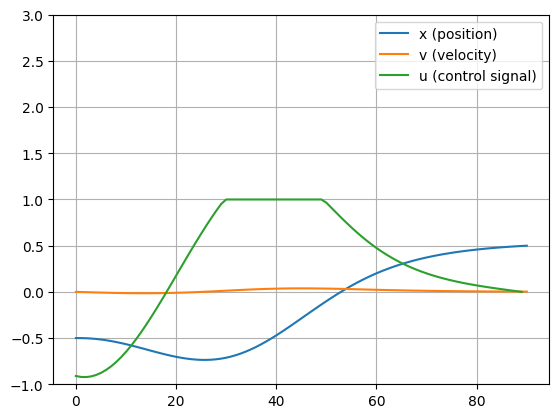

In [36]:
loss = lambda x, u : (x[0] - 0.5) ** 2 + u**2
constraints = Constraints(u={0: [-1, 1]},
                          x_end={0: [0.5, 0.5]},
                          x={0: [-1.2, 0.6],
                             1: [-0.07, 0.07]})

u, x = MultipleShootingMethod([-0.5, 0], 2, 1, 90, dt, model, loss, constraints, debug=True)

plt.plot(x)
plt.plot(u)
plt.grid()
plt.ylim([-1, 3])
plt.legend(['x (position)', 'v (velocity)', 'u (control signal)'])

In [37]:
import gymnasium as gym
env = gym.make('MountainCarContinuous-v0', render_mode="human")
observation, info = env.reset()

for _ in range(1000):
    action = MultipleShootingMethod(list(observation), 2, 1, 100, dt, model, loss, constraints)[0][0]
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        #observation, info = env.reset()
        env.close()

env.close()

error: display Surface quit